In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True })
plt.rc('font', family='serif')
%matplotlib inline

In [2]:
import torch
from torch.utils.data import DataLoader

In [3]:
from MBLlearning.global_config import get_config
import MBLlearning.utils.toy_model as tm
DTYPE, DEVICE = get_config()
print("Using device:",DEVICE)

Using device: cuda


In [4]:
model_filename = "trained_models/toy_model.pt"

retrain_model = False

save_file = None #"plots_paper/toy_model.pdf"

In [5]:
model = tm.GRUnetSimple(2,2,20).to(device=DEVICE,dtype=DTYPE)
data = tm.VarianceDataset([10,12,14,16,18,20],np.arange(0.5,15.5,0.5),1000,2)
dataloader = DataLoader(data,batch_size=32,shuffle=True)

In [6]:
if retrain_model:
    print("Retraining model from scratch ...")
    model, loss = tm.train_simple(model,dataloader,learning_rate=1e-1)
    print("Retraining finished, saving to file.")
    torch.save(model.state_dict(), model_filename)
else:
    print("Trying to load model from file ...")
    try:
        model.load_state_dict(torch.load(model_filename,map_location=DEVICE))
    except:
        print("File not found, training the model ...")
        model, loss = tm.train_simple(model,dataloader,learning_rate=1e-1)
        print("Training finished, saving to file.")
        torch.save(model.state_dict(), model_filename)
    else:
        print("Model loaded from file.")

Trying to load model from file ...
Model loaded from file.


In [7]:
testdata = tm.VarianceDataset([10,16,22,26,30],np.arange(0.5,15.5,0.5),1000,2)

In [8]:
means,mses = tm.eval_model(model,testdata)

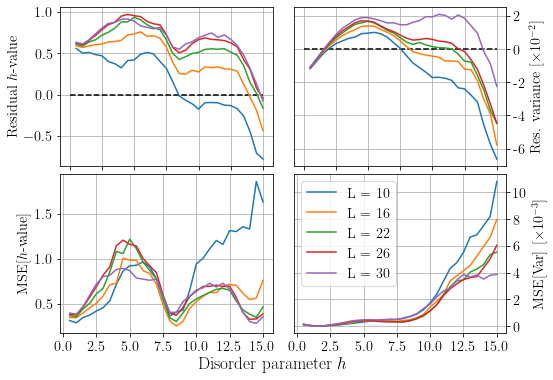

In [9]:
plt.figure(figsize=(8,6))

var = (testdata.h/max(testdata.h))**2/3
for i,(key,diff) in enumerate(zip(["Residual $h$-value",
                                   "Res. variance $[\\times 10^{-2}]$"],[testdata.h,var])):
    ax = plt.subplot(221+i)
    for L,mean in zip(testdata.L_vals,means):
        plt.plot(testdata.h,mean[:,i]-diff,label="L = {}".format(L))
    plt.ylabel(key,fontsize="x-large")
    plt.hlines(0,0,15,colors="k",linestyles="dashed")
    if i==1:
        #plt.legend(fontsize="x-large")
        # set right yticks to right side
        plt.gca().yaxis.set_label_position("right")
        plt.gca().yaxis.set_ticks_position("right")
        plt.yticks(np.arange(-6,3,2)/100,np.arange(-6,3,2),fontsize="x-large")
    else:
        plt.yticks(fontsize="x-large")
    plt.xticks(np.arange(0,16,2.5),[])
    plt.grid()
    
for i,key in enumerate(["MSE[$h$-value]","MSE[Var] $[\\times 10^{-3}]$"]):
    ax = plt.subplot(223+i)
    for L,mse in zip(testdata.L_vals,mses):
        plt.plot(testdata.h,mse[:,i],label="L = {}".format(L))
    plt.ylabel(key,fontsize="x-large")
    if i==1:
        plt.legend(fontsize="x-large")
        # set right yticks to right side
        plt.gca().yaxis.set_label_position("right")
        plt.gca().yaxis.set_ticks_position("right")
        plt.yticks(np.arange(0,11,2)/1000,np.arange(0,11,2),fontsize="x-large")
    else:
        plt.yticks(fontsize="x-large")
    plt.xticks(np.arange(0,16,2.5),np.arange(0,16,2.5),fontsize="x-large")
    plt.grid()
plt.text(-0.1,-0.2,"Disorder parameter $h$",fontsize="xx-large",
                     horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
plt.subplots_adjust(wspace=0.1,hspace=0.05)
if save_file is not None:
    plt.savefig(save_file,orientation="landscape",dpi=600,bbox_inches="tight")
plt.show()

In [15]:
for i in range(26):
    print(chr(ord("a")+i))

a
b
c
d
e
f
g
h
i
j
k
l
m
n
o
p
q
r
s
t
u
v
w
x
y
z
